In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

In [2]:
def theta_dist(theta,nu_type,case):
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
    else:
        print("Not a valid angular distribution!")

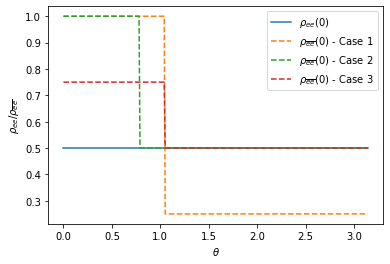

In [3]:
theta_vec=np.arange(0,math.pi,0.01)
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [4]:
def initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_bins,case):
    y0=[] #Initial state
    flavor_sign=1
    omega=delta_m2_31/(2*E_nu*10**6) #eV 

#     theta_vec=np.arange(0,np.pi,theta_step)
    theta_vec=np.linspace(0,np.pi,theta_bins)
    theta_step=theta_vec[1]-theta_vec[0]
    n_theta=len(theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1

    for i in range(n_theta):        
      for j in range(n_f):
        if nu_types[j]=="nu_x":
#           flavor_sign=-1
          flavor_sign=0

        if nu_types[j]=="nu_e":
          flavor_sign=1
        #nu
        nu_spec=theta_dist(theta_vec[i],"nu_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)
        #nubar
        nu_spec=theta_dist(theta_vec[i],"nubar_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)

    #r array
    t_i = (t_i*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_f = (t_f*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_step = t_f/5000 #eV⁻¹
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,theta_vec

In [6]:
t_i,t_f=0,5*10**(-6)
case=1
E_nu=20 #MeV
# theta_step=0.01
theta_bins=200

mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km
nu_types=['nu_e','nu_x']

y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_bins,case)

In [7]:
print("mu=%.1e eV = %.1e s⁻¹"%(mu_0,mu_0*from_eV_to_1_over_m*3*10**8))
print("w=%.1e s⁻¹= %.1e km⁻¹"%(delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8,delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_km))
print("T_vac=%.1e s"%(2*np.pi/(delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8)))
print("t_step=%.1e s"%(t_f/1000))
print("f_sampling = %.1e s⁻¹"%(1/(t_f/5000)))
print("t_f=%.1e km"%(t_f*3*10**5))

mu=2.0e-07 eV = 3.0e+08 s⁻¹
w=9.5e+04 s⁻¹= 3.2e-01 km⁻¹
T_vac=6.6e-05 s
t_step=5.0e-09 s
f_sampling = 1.0e+09 s⁻¹
t_f=1.5e+00 km


In [8]:
def func_Collective_nu_2(y, time, params):
    omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,delta_m2_31))
    L=np.array(L_vec(n_dim))
    
#     r=time/from_eV_to_1_over_km #From eV⁻¹ to km
#     mu=mu_supernova(r,mu_opt,mu_0)
    mu=mu_0
    lamb=lambda_supernova(t,"no",0)
    #print(time/(3*10**5*from_eV_to_1_over_km))

    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim

    #Filling [Theta bin][Nu_types][3components]
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(theta_vec*list(map(sum,nubar_aux[i]))))
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        #P_aux= cross_prod(nu[i][j],(B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        #P_aux= cross_prod(nubar[i][j],(-1*B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [10]:
mass_ord="NH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_bins,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
else:
    print("Not a mass ordering option!")
    
start_time = time.time()
psoln= odeint(func_Collective_nu_2, y0, t, args=(params,))
print("Took %s minutes" % ((time.time() - start_time)/60))

Took 14.737028543154398 minutes


In [9]:
mass_ord="IH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_bins,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
else:
    print("Not a mass ordering option!")
    
start_time = time.time()
psoln_IH= odeint(func_Collective_nu_2, y0, t, args=(params,))
print("Took %s minutes" % ((time.time() - start_time)/60))

KeyboardInterrupt: 

In [34]:
nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))
nu_IH, nubar_IH= read_output(psoln_IH,(n_f,n_dim,n_theta))

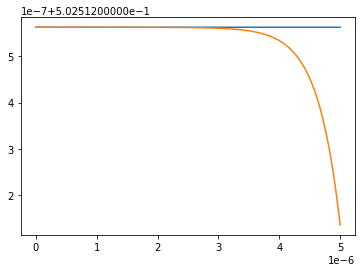

In [39]:
theta_step=np.pi/theta_bins
plt.plot(t/(3*10**5*from_eV_to_1_over_km),np.transpose(nu,(0,1,3,2))[2][0][0]/theta_step)
plt.plot(t/(3*10**5*from_eV_to_1_over_km),np.transpose(nu_IH,(0,1,3,2))[2][0][0]/theta_step)

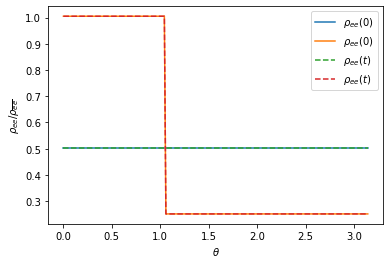

In [14]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
theta_step=np.pi/theta_bins
plt.plot(theta_vec,np.array(nu[2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar[2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu[2][0][-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.plot(theta_vec,np.array(nubar[2][0][-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [17]:
  nu_e_time,nubar_e_time=[],[]
  nu_x_time,nubar_x_time=[],[]

  for l in range(len(nu[0][0])): #time array length
      nu_e_time.append([])
      nubar_e_time.append([])
      nu_x_time.append([])
      nubar_x_time.append([])
    
      for i in range(len(nu[0][0][0])): 
        #nu
        Pee=(1/2)*(1+nu[2][0][l][i]/nu[2][0][0][i])
        Pxx=(1/2)*(1+nu[2][1][l][i]/nu[2][1][0][i])
        if Pxx!=Pxx:
            Pxx=1

        nu_e_time[l].append(Pee*nu[2][0][0][i]+(1-Pxx)*(-1)*nu[2][1][0][i])
        nu_x_time[l].append(Pxx*(-1)*nu[2][1][0][i]+(1-Pee)*nu[2][0][0][i])

        #nubar
        Pee=(1/2)*(1+nubar[2][0][l][i]/nubar[2][0][0][i])
        Pxx=(1/2)*(1+nubar[2][1][l][i]/nubar[2][1][0][i])
        if Pxx!=Pxx:
            Pxx=1

        nubar_e_time[l].append(Pee*nubar[2][0][0][i]+(1-Pxx)*(-1)*nubar[2][1][0][i])
        nubar_x_time[l].append(Pxx*(-1)*nubar[2][1][0][i]+(1-Pee)*nubar[2][0][0][i])

/tmp/ipykernel_9090/1225073773.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Pxx=(1/2)*(1+nu[2][1][l][i]/nu[2][1][0][i])
/tmp/ipykernel_9090/1225073773.py:22: RuntimeWarning: invalid value encountered in double_scalars
  Pxx=(1/2)*(1+nubar[2][1][l][i]/nubar[2][1][0][i])
/tmp/ipykernel_9090/1225073773.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  Pxx=(1/2)*(1+nu[2][1][l][i]/nu[2][1][0][i])
/tmp/ipykernel_9090/1225073773.py:17: RuntimeWarning: invalid value encountered in double_scalars
  nu_e_time[l].append(Pee*nu[2][0][0][i]+(1-Pxx)*(-1)*nu[2][1][0][i])
/tmp/ipykernel_9090/1225073773.py:18: RuntimeWarning: invalid value encountered in double_scalars
  nu_x_time[l].append(Pxx*(-1)*nu[2][1][0][i]+(1-Pee)*nu[2][0][0][i])
/tmp/ipykernel_9090/1225073773.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  Pxx=(1/2)*(1+nubar[2][1][l][i]/nubar[2][1][0][i])
/tmp/ipykernel_9090/1225073773.py:26: RuntimeWarning: invalid value encoun

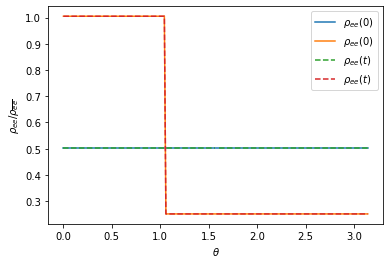

In [19]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
theta_step=np.pi/theta_bins
plt.plot(theta_vec,np.array(nu_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu_e_time[-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.plot(theta_vec,np.array(nubar_e_time[-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [49]:
def func_Collective_nu(y, time, params):
    omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_31))
    L=np.array(L_vec(n_dim))
    
#     r=time/from_eV_to_1_over_km #From eV⁻¹ to km
#     mu=mu_supernova(r,mu_opt,mu_0)
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)
    print(time/(3*10**5*from_eV_to_1_over_km))
    
    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim

    #Filling [Theta bin][Nu_types][3components]
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,1,0))
    nubar_aux=np.transpose(nubar,(2,1,0))

    for i in range(n_dim):
        nu_sum_aux=0
        nubar_sum_aux=0
        nu_sum_theta_aux=0
        nubar_sum_theta_aux=0
        for j in range(n_f):
            for k in range(n_theta):
                nu_sum_aux+=nu[k][j][i]
                nubar_sum_aux+=nubar[k][j][i]
                nu_sum_theta_aux+=np.cos(theta_vec[k])*nu[k][j][i]
                nubar_sum_theta_aux+=np.cos(theta_vec[k])*nubar[k][j][i]
        nu_sum.append(nu_sum_aux)
        nubar_sum.append(nubar_sum_aux)
        nu_sum_theta.append(nu_sum_theta_aux)
        nubar_sum_theta.append(nubar_sum_theta_aux)
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        #P_aux= cross_prod(nu[i][j],(B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        #P_aux= cross_prod(nubar[i][j],(-1*B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [ ]:
mass_ord="IH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
else:
    print("Not a mass ordering option!")
psoln= odeint(func_Collective_nu_2, y0, t, args=(params,))